In [1]:
import torch
import torchvision

from models import LFADS
from utils import read_data, load_parameters, save_parameters, batchify_random_sample

np = torch._np
import matplotlib.pyplot as plt
import yaml
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


In [3]:
author = 'lyprince'
seed = 100
if os.path.exists('./synth_data/lorenz_100'):
    data_dict = read_data('./synth_data/lorenz_100')
else:
    from synthetic_data import generate_lorenz_data
    data_dict = generate_lorenz_data(N_cells=30, N_inits=65, N_trials=20, N_steps=200, N_stepsinbin=2, dt_lorenz=0.015, dt_spike = 1./20, base_firing_rate= 1.0, save=True)

# For spike data
train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

train_truth = {'rates'  : data_dict['train_rates'],
               'latent' : data_dict['train_latent']}

valid_truth = {'rates'  : data_dict['valid_rates'],
               'latent' : data_dict['valid_latent']}

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape;
print(train_data.shape);
print('Number of datapoints = %s'%train_data.numel())

torch.Size([1040, 100, 30])
Number of datapoints = 3120000


In [4]:
hyperparams = load_parameters('./parameters/parameters_lorenz_spikes.yaml')
hyperparams['run_name'] += '_demo'
save_parameters(hyperparams, path=None)

hyperparams

{'betas': (0.9, 0.99),
 'clip_val': 5.0,
 'dataset_name': 'lorenz',
 'datatype': 'spikes',
 'epsilon': 0.1,
 'factors_dim': 3,
 'g0_encoder_dim': 64,
 'g0_prior_kappa': 0.1,
 'g0_prior_var_max': 0.1,
 'g0_prior_var_min': 0.1,
 'g_dim': 64,
 'keep_prob': 0.95,
 'kernel_dim': 20,
 'kl_weight_min': 0.0,
 'kl_weight_schedule_dur': 1600,
 'kl_weight_schedule_start': 0,
 'l2_con_scale': 0,
 'l2_gen_scale': 250,
 'l2_weight_min': 0.0,
 'l2_weight_schedule_dur': 1600,
 'l2_weight_schedule_start': 0.0,
 'learning_rate': 0.01,
 'learning_rate_decay': 0.95,
 'learning_rate_min': 1e-05,
 'max_norm': 200,
 'norm_factors': True,
 'run_name': 'poisson_demo',
 'scheduler_cooldown': 6,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'u_dim': 0,
 'u_prior_kappa': 0.1,
 'use_weight_schedule_fn': True}

In [5]:
model = LFADS(inputs_dim = num_cells, T = num_steps, dt = float(data_dict['dt']), device=device,
              model_hyperparams=hyperparams).to(device)

Random seed: 5902


In [6]:
model.load_checkpoint('recent')

In [7]:
model.fit(train_ds, valid_ds, train_truth=train_truth, valid_truth=valid_truth,
          max_epochs=2000, batch_size=65, use_tensorboard=True, health_check=False)

Beginning training...
Epoch:  444, Step:  7104, training loss: 1142.158, validation loss: 1141.922
Epoch:  445, Step:  7120, training loss: 1141.241, validation loss: 1142.097
Epoch:  446, Step:  7136, training loss: 1140.827, validation loss: 1141.222
Epoch:  447, Step:  7152, training loss: 1140.319, validation loss: 1141.527
Epoch:  448, Step:  7168, training loss: 1140.919, validation loss: 1142.672
Epoch:  449, Step:  7184, training loss: 1142.214, validation loss: 1142.097
Learning rate decreased to 0.001661
Epoch:  450, Step:  7200, training loss: 1141.501, validation loss: 1142.363
Epoch:  451, Step:  7216, training loss: 1141.059, validation loss: 1144.494
Epoch:  452, Step:  7232, training loss: 1140.553, validation loss: 1141.950
Epoch:  453, Step:  7248, training loss: 1141.587, validation loss: 1143.255
Epoch:  454, Step:  7264, training loss: 1141.769, validation loss: 1142.650
Epoch:  455, Step:  7280, training loss: 1141.045, validation loss: 1141.408
Epoch:  456, Step:

In [8]:
model.load_checkpoint('best')

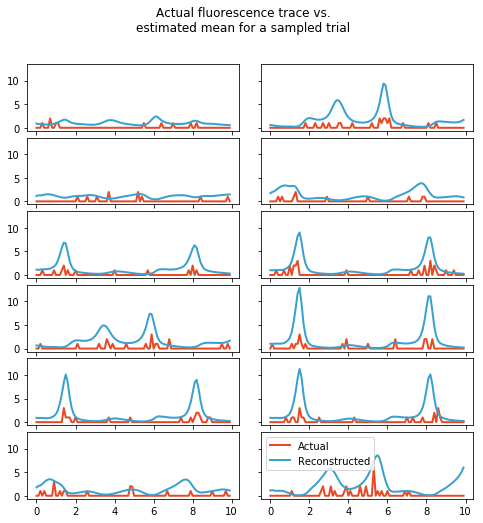

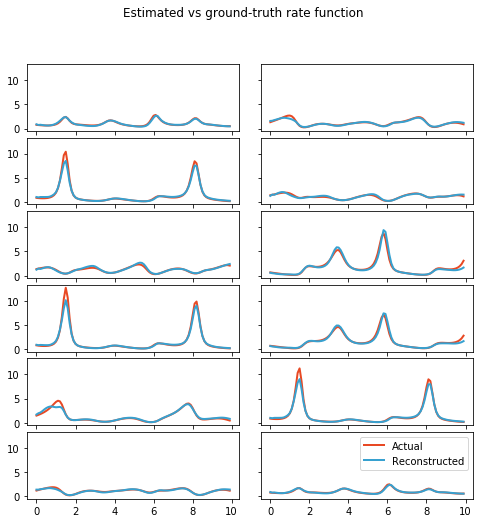

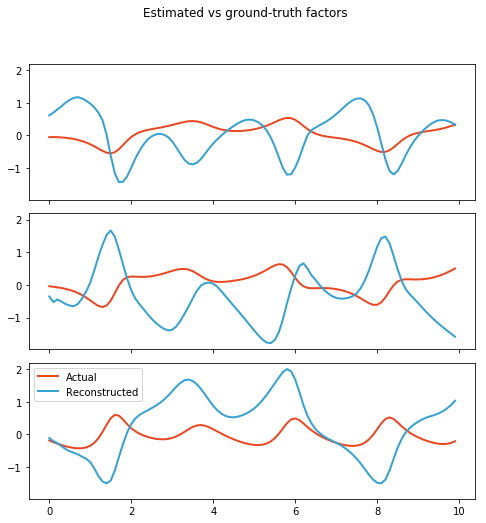

In [14]:
fig_dict = model.plot_summary(data=valid_data, truth=valid_truth)

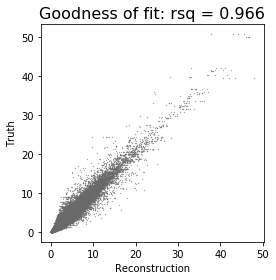

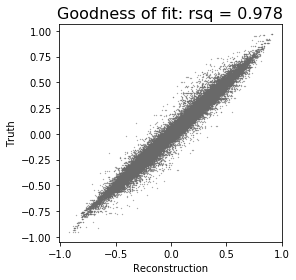

In [15]:
results_dict = model.plot_recon_rsquared(valid_data, valid_truth, train_data, train_truth)

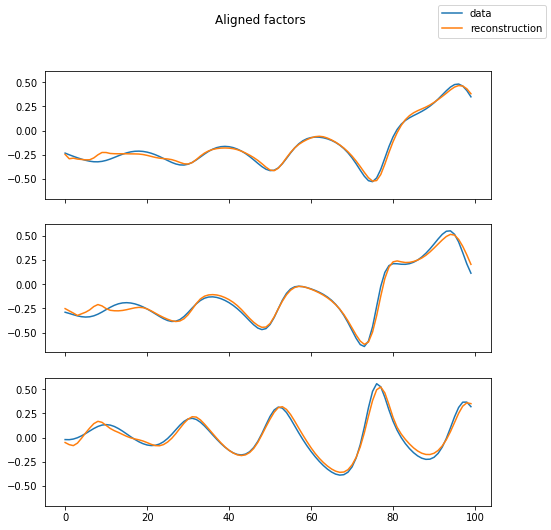

In [29]:
fig, axs = plt.subplots(figsize=(8,8), nrows=3, ncols=1, sharex=True, sharey=True)
for ix in range(3):
    plt.sca(axs[ix])
    plt.plot(data_dict['valid_latent'][0, :100, ix])
    plt.plot(results_dict['factors']['aligned'][:100, ix])
    
fig.suptitle('Aligned factors')
fig.legend(['data', 'reconstruction'])